In [1]:
import numpy as np
import pandas as pd
import cudaq
from cudaq import spin
from typing import List, Tuple
import matplotlib.pyplot as plt
from math import sqrt
import math
import sys
import os
import torch
sys.path.append(os.path.abspath(".."))
from Utils.qaoaCUDAQ import po_normalize, ret_cov_to_QUBO, qubo_to_ising, process_ansatz_values, state_to_return, pauli_to_int, int_to_pauli,\
    basis_T_to_pauli, reversed_str_bases_to_init_state, kernel_qaoa_Preserved, kernel_qaoa_X, get_optimizer

import seaborn as sns
from copulas.multivariate import GaussianMultivariate
import joblib

import time
cudaq.set_target("nvidia")
np.random.seed(50)
state = np.random.get_state()
modes = ["X", "Preserving"]

# PIPELINE PARAMETERS
LOOP = 100
oversample_factor = 2.1
over_budget_bound = 1.0 # valid budget in [0, B * over_budget_bound]
init_state_ratio = 0.02
min_P, max_P = 100, 300
hamiltonian_boost = 100

# HYPER PARAMETERS
TARGET_QUBIT = 10
N_ASSETS = 3
LAMB = 1.5 # Budget Penalty
Q = 0 # Volatility Weight

(323, 2)


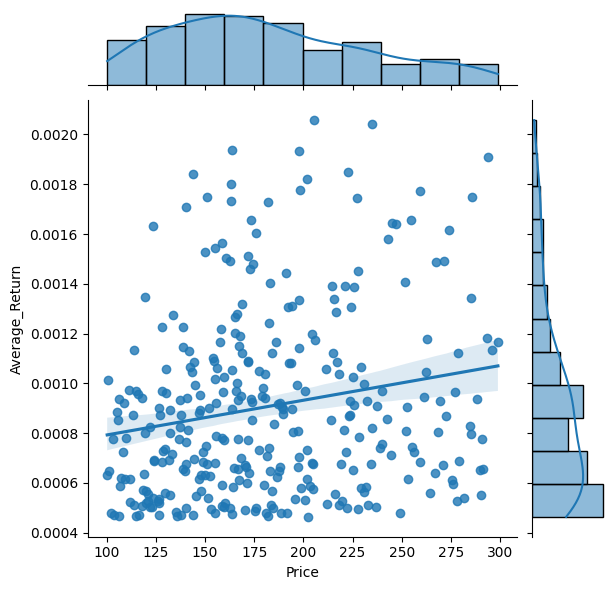

In [2]:

np.random.set_state(state)
GM_loaded = joblib.load('./models/gaussian_copula.pkl')
# samples = GM_loaded.sample(50)
samples = GM_loaded.sample(int(N_ASSETS * LOOP * oversample_factor))
samples = samples[(samples["Price"] > min_P) & (samples["Price"] < max_P)]
# print(samples["Average_Return"].min(), samples["Average_Return"].max())
# print(samples["Price"].min(), samples["Price"].max())
print(samples.shape)
assert samples.shape[0] > N_ASSETS * LOOP, "Please increase the oversample factor to get more samples ;-;"
sns.jointplot(data=samples, x='Price', y='Average_Return', kind='reg')
samples = samples.to_numpy()
plt.show()

In [3]:
def find_budget(target_qubit, P):
    n_assets = len(P)
    mi, ma = 0, max_P * ((1 << math.ceil(target_qubit/n_assets))-1)
    cou = 0
    mid = (mi + ma)/2
    while (N := np.sum(np.int32(np.floor(np.log2(mid/P))) + 1)) != target_qubit:
        if N < target_qubit:
            mi = mid
        else:
            ma = mid
        # print()
        mid = (mi + ma)/2
        cou += 1
        if cou > 100:
            assert False, "Cannot find budget for target qubit (Should not happen, Please tell trusted adult lol)"
    return mid

# a = np.array([186, 195, 131])
# b = find_budget(22, a)
# print(b)
# print(np.int32(np.floor(np.log2(b/a))) + 1)

In [4]:
def all_state_to_return(B, C, d_ret, d_p, over_budget_bound):
    qb = C.shape[1]
    l = np.zeros((1<<qb, qb))
    P = d_p @ C
    ret_C = (d_ret * d_p) @ C
    for i in range(1<<qb):
        s = bin(i)[2:].zfill(qb)
        ll = np.array(list(map(int, s)))
        l[i] = ll
    ss = l @ ret_C
    bud = l @ P
    return ss, bud <= B * over_budget_bound

def get_init_states(state_return, in_budget, init_state_ratio, n_qubits):
    sorted_idx = np.argsort(-state_return)
    N = int(len(state_return) * init_state_ratio)
    init_states = []
    cou = 0
    for i in sorted_idx:
        if in_budget[i]:
            init_states.append(bin(i)[2:].zfill(n_qubits))
            cou += 1
        if cou >= N:
            break
    return init_states

In [5]:
a = np.arange(10)
print(a[:2])

[0 1]


In [6]:
print(bin(2)[2:].zfill(5))
print(bin(2)[2:].zfill(5)[::-1])

00010
01000


In [7]:
for i in range(LOOP):
    st = time.time()

    P = samples[i * N_ASSETS:(i + 1) * N_ASSETS, 0]
    ret = samples[i * N_ASSETS:(i + 1) * N_ASSETS, 1]
    # print(P)
    # print(ret)
    
    # P = np.array([195.27, 183.26, 131.3])
    # ret = np.array([0.00107, 0.00083, 0.00071])
    cov = np.random.rand(N_ASSETS, N_ASSETS)
    cov += cov.T
    q = 0 # Volatility Weight
    B = find_budget(TARGET_QUBIT, P)
    # print(B)
    # break
    # B = 270
    P_bb, ret_bb, cov_bb, n_qubit, n_max, C = po_normalize(B, P, ret, cov)
    state_return, in_budget = all_state_to_return(B, C, ret, P, over_budget_bound)
    init_state = get_init_states(state_return, in_budget, init_state_ratio, n_qubit)

    ed = time.time() - st
    print(f"initial: {ed*1000:.2f} ms.")

    for mode in modes:
        st = time.time()
        lamb = LAMB if mode == "X" else 0 # Budget Penalty

        QU = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
        H = qubo_to_ising(QU, lamb).canonicalize() * (1 if mode == "X" else hamiltonian_boost)
        idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use = process_ansatz_values(H)

        kernel_qaoa_use = kernel_qaoa_X if mode == "X" else kernel_qaoa_Preserved

        idx = 3
        layer_count = 5
        parameter_count = layer_count * 2
        optimizer, optimizer_name, FIND_GRAD = get_optimizer(idx)
        optimizer.max_iterations = 1000

        if mode == "X":
            ansatz_fixed_param = (int(n_qubit), layer_count, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use)
            ed = time.time() - st
            print(f"init for {mode}: {ed*1000:.2f} ms.")
        else:
            n_bases = len(init_state)
            print("n_bases:", n_bases)
            T = np.zeros((n_bases, n_bases), dtype=np.float32)
            T[:-1, 1:] += np.eye(n_bases - 1, dtype=np.float32)
            T[1:, :-1] += np.eye(n_bases - 1, dtype=np.float32)
            T[0, -1] = T[-1, 0] = 1.0
            # print(T)
            mixer_s, mixer_c = basis_T_to_pauli(init_state, T, n_qubit)
            init_bases = reversed_str_bases_to_init_state(init_state, n_qubit)
            ansatz_fixed_param = (int(n_qubit), layer_count, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, mixer_s, mixer_c, init_bases)
            print(f"Init for {mode}: {ed*1000:.2f} ms.")
        # print(cudaq.draw(kernel_qaoa_use, [0.5]*4, *ansatz_fixed_param[:1], 1, *ansatz_fixed_param[2:]))

        st = time.time()
        # expectations = []
        def cost_func(parameters):
            # return cudaq.observe(kernel_qaoa, H, n_qubit, layer_count, parameters, 0).expectation()
            return cudaq.observe(kernel_qaoa_use, H, parameters, *ansatz_fixed_param).expectation()

        def objective(parameters):
            expectation = cost_func(parameters)
            # expectations.append(expectation)
            return expectation

        def objective_grad_cuda(parameters):
            expectation = cost_func(parameters)
            # expectations.append(expectation)

            gradient = cudaq.gradients.ForwardDifference().compute(parameters, cost_func, expectation)

            return expectation, gradient

        objective_func = objective_grad_cuda if FIND_GRAD else objective

        optimal_expectation, optimal_parameters = optimizer.optimize(
            dimensions=parameter_count, function=objective_func)
        ed = time.time() - st
        print(f"Optimization for {mode}: {ed*1000:.2f} ms.")
        
        st = time.time()
        result = cudaq.get_state(kernel_qaoa_use, optimal_parameters, *ansatz_fixed_param)
        idx_r_best = np.argmax(np.abs(result))
        idx_best = bin(idx_r_best)[2:].zfill(n_qubit)[::-1]
        ed = time.time() - st
        print(f"Observation: {ed*1000:.2f} ms.")

        print(idx_best, init_state[0])
        print(state_return[int(idx_best, 2)], in_budget[int(idx_best, 2)], state_return[int(init_state[0], 2)], in_budget[int(init_state[0], 2)])


    break


initial: 1.52 ms.
init for X: 1.54 ms.
Optimization for X: 3301.11 ms.
Observation: 3.85 ms.
0000000000 1011000000
0.0 True 1.3965033286869675 True
n_bases: 20
Init for Preserving: 3.85 ms.
Optimization for Preserving: 6960.72 ms.
Observation: 277.35 ms.
1010000000 1011000000
1.2881427885416623 True 1.3965033286869675 True


In [8]:
a = torch.arange(10)
aa = torch.tensor(a, device='cuda')

ab = torch.abs(aa)
am = torch.argmax(ab)

/tmp/ipykernel_90579/3788695641.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aa = torch.tensor(a, device='cuda')


In [9]:
a = np.zeros((1<<25), dtype=np.complex64)

In [11]:
# for i in result.getTensors():
#     print(i.)

In [ ]:
st = time.time()
# result = cudaq.get_state(kernel_qaoa_use, optimal_parameters, *ansatz_fixed_param)
torch.argmax(torch.abs(torch.tensor(np.array(result), device='cuda')))
# am = np.argmax(np.abs(a))
# am = np.argmax(np.abs(result))

ed = time.time() - st
print(f"Observation: {ed*1000:.2f} ms.")

Observation: 0.67 ms.


In [ ]:
# import numpy as np
# import torch as th
# c=np.random.rand(10000000).astype(np.float32) # cpu version
# g=th.tensor(c).to(device='cuda:0')             # gpu version
# %timeit -n 10 np.median(c,axis=0)    
# %timeit -n 10 np.sort(c,axis=0)[1]      
# %timeit -n 10 th.median(g,dim=0).values 
# %timeit -n 10 th.sort(g,dim=0).values[1]

59.8 ms ± 111 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)

587 ms ± 242 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)

246 μs ± 591 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)

41.9 ms ± 102 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)